Instalando as bibliotecas para importar os dados do *BigQuery*

In [1]:
!pip install google-cloud-bigquery
!pip install pandas-gbq
!pip install statsforecast
!pip install hierarchicalforecast

# 1. Consultas das tabelas do *BigQuery*

In [2]:
# Import do autenticador:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import auth
auth.authenticate_user()
from google.cloud import bigquery

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Instanciam-se as tabelas que serão utilizadas:

project_id = 'adventureworks-413718'
schema_id = 'dbt_dteixeira'
fact_table = 'fact_sales'
dim_customers = 'dim_customers'
dim_products = 'dim_products'
dim_territory = 'dim_territory'
stg_person = 'stg_person'

In [4]:
client = bigquery.Client(project=project_id)

In [5]:
# Instancia-se a tabela fato:

fact = client.query(f"select * from {schema_id}.{fact_table}").to_dataframe() # to_dataframe() para que a variável seja um dataframe do pandas
fact.head()

,sksales,salesorderid,orderdate,duedate,shipdate,status,onlineorderflag,fkcustomer,customerid,salespersonid,...,fklocation,shiptoaddressid,fkcreditcard,creditcardid,salesorderdetailid,fkproduct,productid,orderqty,totaldue,fkreason
0,bc0ad686f39521e12d7989a9ce6d8ec4,45397,2012-01-09,2012-01-21,2012-01-16,Shipped,Online,e6381086c065306fb015d019a2b1b037,15051,0,...,401b6f70039eba74c261ee85f9fd261c,11901,2d49618fb37cd5e33651acfeca2b4442,13711,6635,2206935164eabed036abe43bc70c913c,752,1,3578.2700,2bb43c6e94f7536e7157d5a9ac63200b
1,0705c458afe34df127aa9321c309fb9e,45398,2012-01-09,2012-01-21,2012-01-16,Shipped,Online,55276fb18e22228bf42dd625604844c3,15059,0,...,c02fdf861c5c130029f916c48d1b6756,11449,c5e3158d824fae5300a2d6c0cdac0402,11872,6636,170008e299ef057a0c4091c731a2240a,751,1,3578.2700,d848c92a1a59beb82bf81d3530cb8b18
2,2e52c4ab410b5947450cf110c39ae538,45399,2012-01-09,2012-01-21,2012-01-16,Shipped,Online,189f64c3cd3016c04ac3f8c31a3acc27,19598,0,...,6dbf009b03a770ee34fe06955e54b591,29728,None,<NA>,6637,657d6937061d1c5c30db4b17c35e60db,750,1,3578.2700,4ade1611f78dc69fa70fb05af7c6b49d
3,b50515fbc7e6b9e46a5f44782a390075,47896,2012-09-21,2012-10-03,2012-09-28,Shipped,Online,8845978a1d86e31f1d4d20f0d8802508,17206,0,...,fe31e9f54d4487259472a533a4aa8de5,22235,053816c6377ffd754b81bc8baaf4a39e,3732,19841,0c8dab68307022151a51e485aa2b1ca7,801,1,1000.4375,751995935d537efcc7dd22fcf8a76c2b
4,4f3c1674b18499540cbf5494dedcbea2,47897,2012-09-21,2012-10-03,2012-09-28,Shipped,Online,a5a53a06c4248317567fba5315154083,16573,0,...,024ac6c9fa257be026915c8b2d5154fe,20338,2c77e58b19db3ac189ea49218302fbfc,6370,19842,67c142b389dc026cbcc5b7abaae39731,795,1,2181.5625,d59ab263f6f0828d3252d5aed113eba3


In [6]:
# A dimensão de clientes:

customers = client.query(f"select * from {schema_id}.{dim_customers}").to_dataframe()
customers.head()

,skcustomer,customerid,personid,storeid,name,salespersonid,store_name,territoryid,emailpromotion
0,771214111c00677f8018cd71585d40bc,11785,6721,<NA>,Theodore D Diaz,<NA>,None,1,No promotional e-mail
1,c0d0b719f213fde6c6589d7897faf726,13070,11884,<NA>,Emma D Clark,<NA>,None,1,No promotional e-mail
2,817d2c0c0333c9d97e7ed4abfee59617,13087,4059,<NA>,Jeremy Collins,<NA>,None,1,No promotional e-mail
3,d3d02af293dd384d83f8ba34a42fa73d,13397,16512,<NA>,Adam Mitchell,<NA>,None,1,No promotional e-mail
4,8e57a0cf0ad14f999d4fefec1f661a52,14916,7789,<NA>,Paige C Washington,<NA>,None,1,No promotional e-mail


In [7]:
# Instancia-se a dimensão de produtos:

products = client.query(f"select * from {schema_id}.{dim_products}").to_dataframe()
products.head()

,skproduct,productid,name_product,color,listprice,sellstartdate,productsubcategoryid,name_category
0,38babc9caa2c3230252e9bd7a1770c35,397,Hex Nut 19,None,0E-9,2008-04-30,<NA>,Other
1,600924f3f4f2e212e8acb9dc95b72396,434,Thin-Jam Lock Nut 7,None,0E-9,2008-04-30,<NA>,Other
2,0f8d5b07e08f7dbff9728963b019fe20,491,HL Nipple,None,0E-9,2008-04-30,<NA>,Other
3,12725417882b0c07e4d7b1658d769e84,510,LL Road Rim,None,0E-9,2008-04-30,<NA>,Other
4,ceb0499968e1c4b62d9f5ef07582d1d2,411,External Lock Washer 2,None,0E-9,2008-04-30,<NA>,Other


In [8]:
# Instancia-se a dimensão de território:

territory = client.query(f"select * from {schema_id}.{dim_territory}").to_dataframe().rename({'name': 'territoryname'}, axis=1)
territory.head()

,skterritory,territoryid,territoryname,countryregioncode,macrogroup
0,cb031113acc16953028f123e1160a35e,8,Germany,DE,Europe
1,5544b6bff812b783446661aa4b629109,7,France,FR,Europe
2,3de7b74da82020dd32fa2cbc1313c2cd,10,United Kingdom,GB,Europe
3,1b94aa6c3920193f5d6371efbae87386,9,Australia,AU,Pacific
4,a560839d4f406a16743bab52e43915c6,6,Canada,CA,North America


In [9]:
# A staging de pessoas:

person = client.query(f"select * from {schema_id}.{stg_person}").to_dataframe()
person.head()

,businessentityid,persontype,title,firstname,middlename,lastname,emailpromotion
0,3,EM,None,Roberto,None,Tamburello,0
1,4,EM,None,Rob,None,Walters,0
2,41,EM,None,Bryan,None,Baker,0
3,99,EM,None,Nuan,None,Yu,0
4,146,EM,None,Jian Shuo,None,Wang,0


# 2. *Join* das tabelas para formar ter os dados necessários

In [10]:
# É feito o merge na tabela fato e dimensão de clientes:

sales_customers = pd.merge(
  left=fact, right=customers[['customerid', 'storeid', 'name', 'store_name']], how='left',
  left_on='customerid', right_on='customerid'
)

In [11]:
# Da tabela de produtos para obter o nome dos produtos:

sales_products = pd.merge(
    left=sales_customers, right=products[['productid', 'name_product', 'name_category']], how='left',
    left_on='productid', right_on='productid'
)

In [12]:
sales_territory = pd.merge(
    left=sales_products, right=territory[['territoryid', 'territoryname']], how='left',
    left_on='territoryid', right_on='territoryid'
)

In [13]:
# E da tabela de pessoas, a fim de obter o nome dos vendedores:

sales = pd.merge(
    left=sales_territory, right=person[['businessentityid', 'firstname', 'middlename', 'lastname', 'persontype']],
    how='left', left_on='salespersonid', right_on='businessentityid'
)

# 3. Tratamento da tabela *sales*

O objetivo é limpar a tabela para obter apenas as informações necessárias para agregá-las para os passos da modelagem de séries temporais.

In [14]:
# A coluna com nome do vendedor será a união entre as colunas firstname, middlename e lastname:

sales['salespersonname'] = sales['firstname'] + ' ' + sales['middlename'] + ' ' + sales['lastname']

In [15]:
# Seleciona-se as colunas de interesse:

sales = sales[
    ['orderdate', 'store_name', 'name_product', 'salespersonname',
     'territoryname', 'orderqty', 'totaldue', 'name_category']
]

In [16]:
sales.sample(20)

,orderdate,store_name,name_product,salespersonname,territoryname,orderqty,totaldue,name_category
42953,2014-05-01,Safe Cycles Shop,Chain,David R Campbell,Northwest,4,48.5760,Components
55061,2013-09-09,None,ML Mountain Tire,NaN,Australia,1,29.9900,Accessories
6427,2014-03-01,Mountain Bike Store,"Touring-3000 Blue, 44",Michael G Blythe,Northeast,2,890.8200,Bikes
77905,2013-10-30,Educational Services,"Classic Vest, M",Rachel B Valdez,Germany,3,114.3000,Clothing
41138,2014-05-01,Metropolitan Bicycle Supply,"Mountain-200 Black, 46",Jae B Pak,United Kingdom,5,6884.9700,Bikes
107341,2013-04-30,Elite Bikes,"Sport-100 Helmet, Black",NaN,Southwest,3,60.5595,Accessories
19001,2012-10-30,Sundry Sporting Goods,"Women's Tights, L",José Edvaldo Saraiva,Canada,3,134.9820,Clothing
37221,2014-04-22,None,"Sport-100 Helmet, Black",NaN,Australia,1,34.9900,Accessories
84402,2013-11-16,None,"Road-250 Black, 52",NaN,United Kingdom,1,2443.3500,Bikes
57666,2012-12-31,Satin Finish Company,"Full-Finger Gloves, L",NaN,Southwest,2,45.5880,Clothing


## 3.1. Tratamento dos dados faltantes

Há alguns dados faltantes que ocorrem em decorrência da natureza da compra, isto é, a compra pode ser feita *online* ou a partir de revendedores (*stores*). Portanto, onde há dados faltantes em `salespersonname` e `store_name` se deve à modalidade da compra. Uma análise dos *missing values*:

In [17]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121317 entries, 0 to 121316
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   orderdate        121317 non-null  dbdate 
 1   store_name       60919 non-null   object 
 2   name_product     121317 non-null  object 
 3   salespersonname  53384 non-null   object 
 4   territoryname    121317 non-null  object 
 5   orderqty         121317 non-null  Int64  
 6   totaldue         121317 non-null  float64
 7   name_category    121317 non-null  object 
dtypes: Int64(1), dbdate(1), float64(1), object(5)
memory usage: 8.4+ MB


Depreende-se que estes só estão justamente nas colunas citadas anteriormente. Portanto, os registros vazios serão preenchidos com valores em referência à modalidade da compra.

In [18]:
sales['store_name'] = sales['store_name'].fillna('Ecommerce') # preenchimento da coluna store_name

In [19]:
sales['salespersonname'] = sales['salespersonname'].fillna('Online') # preenchimento da coluna salespersonname

In [20]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121317 entries, 0 to 121316
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   orderdate        121317 non-null  dbdate 
 1   store_name       121317 non-null  object 
 2   name_product     121317 non-null  object 
 3   salespersonname  121317 non-null  object 
 4   territoryname    121317 non-null  object 
 5   orderqty         121317 non-null  Int64  
 6   totaldue         121317 non-null  float64
 7   name_category    121317 non-null  object 
dtypes: Int64(1), dbdate(1), float64(1), object(5)
memory usage: 8.4+ MB


Agora todos os valores estão preenchidos.

In [21]:
sales = sales.rename({'store_name': 'storename', 'name_product': 'productname', 'name_category': 'categoryname'}, axis=1)

## 3.2. Coluna `orderdate` para período mensal

A estimativa da demanda se dará no período mensal. Portanto, é necessário que esta coluna atenda essa exigência. Para isso:

In [22]:
# sales['orderdate'] = pd.to_datetime(sales['orderdate']).to_period('M')

In [23]:
sales['orderdate'] = pd.to_datetime(sales['orderdate']).dt.to_period('M')

# 4. Análise exploratória dos dados

## 4.1. Coluna `storename`

In [24]:
# Frequência das lojas:

sales['storename'].value_counts()

Ecommerce                     60398
Vigorous Exercise Company       530
Larger Cycle Shop               482
Retail Mall                     451
Rapid Bikes                     446
                              ...  
Widget Bicycle Specialists        1
Mobile Outlet                     1
Hometown Riding Supplies          1
Tubeless Tire Company             1
Weekend Bike Tours                1
Name: storename, Length: 634, dtype: int64

Percebe-se que, por muito, a maior parte das vendas da Adventure Works se dá no ambiente *online*.

In [25]:
most_frequent_stores = sales['storename'].value_counts().head(10)

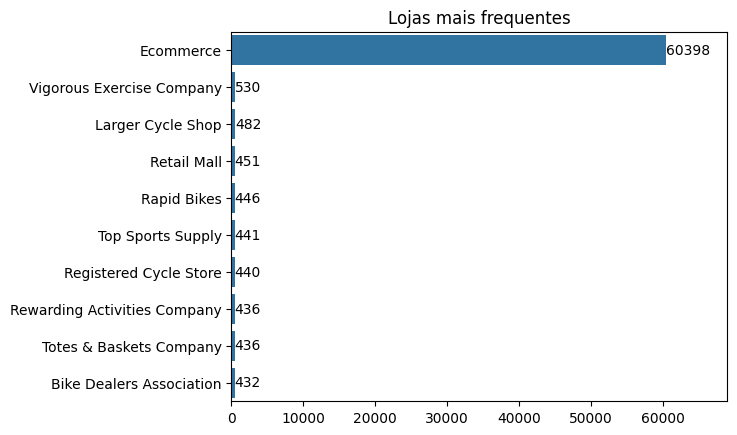

In [26]:
# Gráfico com as lojas mais frequentes:

ax = sns.barplot(x=most_frequent_stores.values, y=most_frequent_stores.keys())
ax.set_title('Lojas mais frequentes')
ax.set_ylabel('')

for container in ax.containers:
  ax.bar_label(container, label_type='edge')

ax.set_xlim([0, 69000])
plt.show()

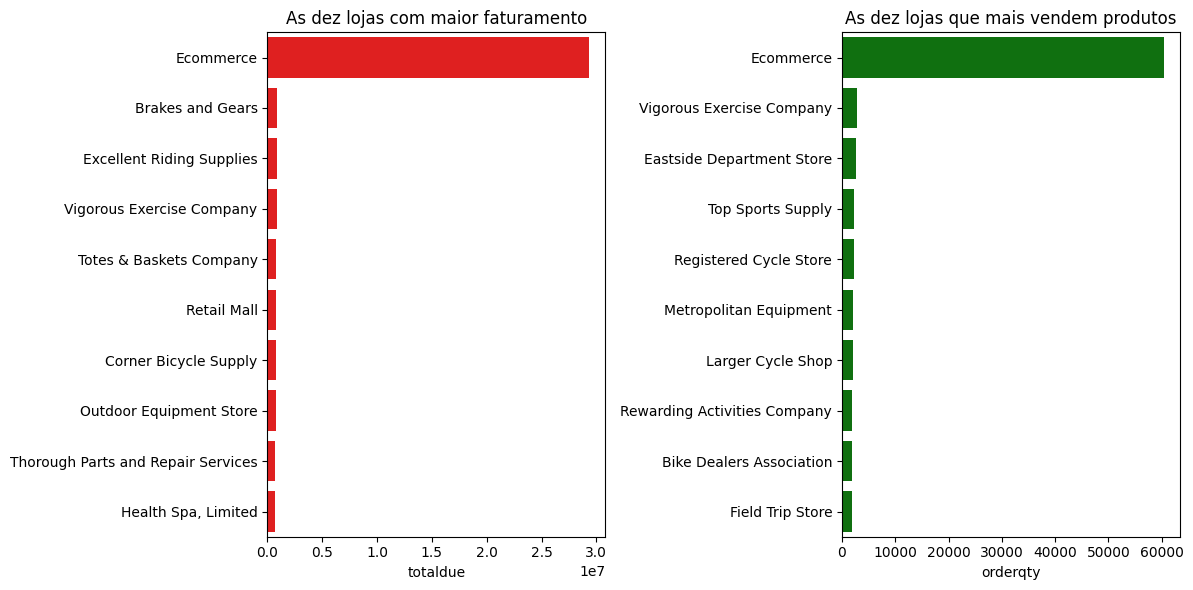

In [27]:
grouped_store = sales.groupby('storename')[['orderqty', 'totaldue']].sum()

# As lojas que mais venderam produtos e com maiores faturamentos:

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax1 = sns.barplot(data=grouped_store.sort_values('totaldue', ascending=False).head(10) , x='totaldue', y='storename', color='red', ax=ax[0])
ax1.set_title('As dez lojas com maior faturamento')
ax1.set_ylabel("")
ax2 = sns.barplot(data=grouped_store.sort_values('orderqty', ascending=False).head(10), x='orderqty', y='storename', color='green', ax=ax[1])
ax2.set_title('As dez lojas que mais vendem produtos')
ax2.set_ylabel("")
plt.tight_layout()
plt.show()

## 4.2. Coluna `productname`

In [28]:
# Número de produtos únicos no dataset:

sales['productname'].nunique()

266

In [29]:
# Frequência dos produtos no dataset:

sales['productname'].value_counts()

Water Bottle - 30 oz.               4688
AWC Logo Cap                        3382
Patch Kit/8 Patches                 3354
Mountain Tire Tube                  3095
Sport-100 Helmet, Blue              3090
                                    ... 
LL Mountain Frame - Black, 52          9
LL Mountain Frame - Black, 40          6
LL Road Seat/Saddle                    6
ML Mountain Frame-W - Silver, 38       5
LL Touring Frame - Blue, 58            2
Name: productname, Length: 266, dtype: int64

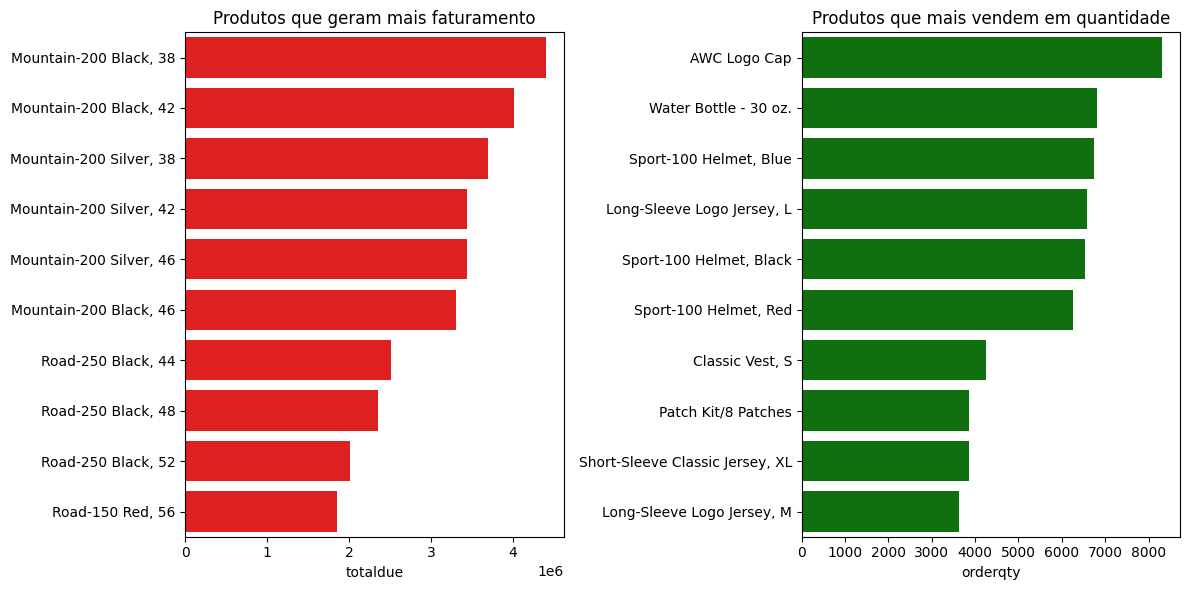

In [30]:
grouped_products = sales.groupby('productname')[['orderqty', 'totaldue']].sum()

# Faturamento por produto e quantidade:

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax1 = sns.barplot(data=grouped_products.sort_values('totaldue', ascending=False).head(10) , x='totaldue', y='productname', color='red', ax=ax[0])
ax1.set_title('Produtos que geram mais faturamento')
ax1.set_ylabel("")
ax2 = sns.barplot(data=grouped_products.sort_values('orderqty', ascending=False).head(10), x='orderqty', y='productname', color='green', ax=ax[1])
ax2.set_title('Produtos que mais vendem em quantidade')
ax2.set_ylabel("")
plt.tight_layout()
plt.show()

## 4.3. Coluna `salespersonname`

In [31]:
# Quantidade distinta de vendedores:

sales['salespersonname'].nunique()

13

In [32]:
# Frequência de cada vendedor:

sales['salespersonname'].value_counts(ascending=False)

Online                        67933
Shu K Ito                      8885
José Edvaldo Saraiva           8115
Michael G Blythe               7658
Tsvi Michael Reiter            5477
Ranjit R Varkey Chudukatil     3530
Jae B Pak                      3520
David R Campbell               3451
Garrett R Vargas               3329
Linda C Mitchell               2952
Pamela O Ansman-Wolfe          2851
Rachel B Valdez                1903
Lynn N Tsoflias                1713
Name: salespersonname, dtype: int64

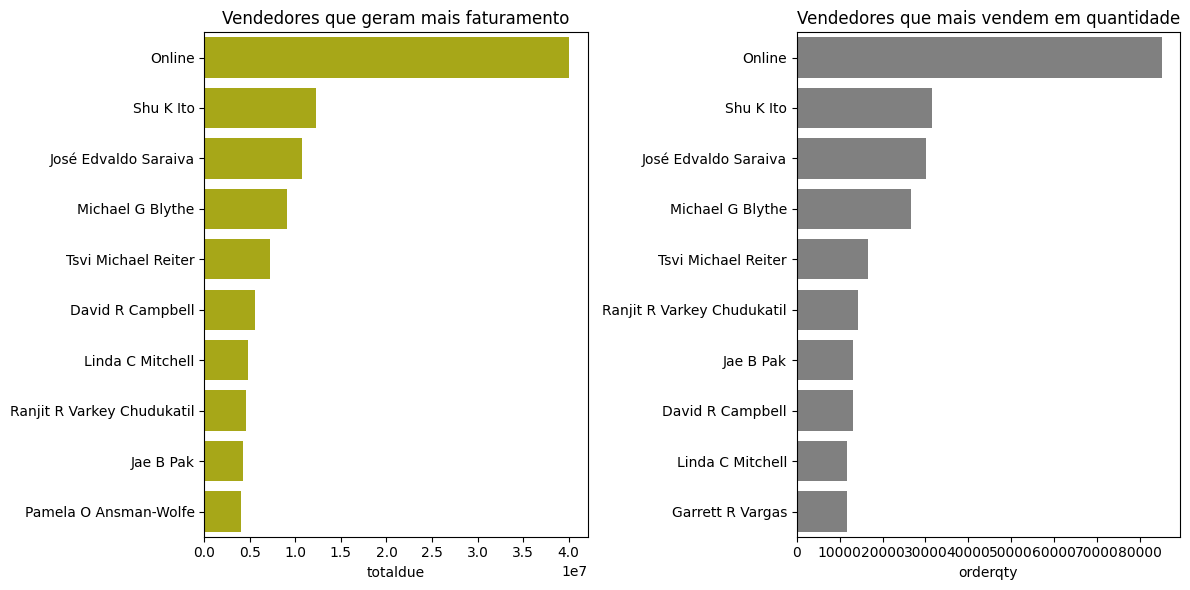

In [33]:
grouped_salesperson = sales.groupby('salespersonname')[['orderqty', 'totaldue']].sum()

# Vendas por produto e faturamento para cada vendedor:

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax1 = sns.barplot(data=grouped_salesperson.sort_values('totaldue', ascending=False).head(10) , x='totaldue', y='salespersonname', color='y', ax=ax[0])
ax1.set_title('Vendedores que geram mais faturamento')
ax1.set_ylabel("")
ax2 = sns.barplot(data=grouped_salesperson.sort_values('orderqty', ascending=False).head(10), x='orderqty', y='salespersonname', color='gray', ax=ax[1])
ax2.set_title('Vendedores que mais vendem em quantidade')
ax2.set_ylabel("")
plt.tight_layout()
plt.show()

## 4.4. Coluna `territoryname`

In [34]:
# Os valores distintos para coluna territoryname:

sales['territoryname'].unique()

array(['United Kingdom', 'Australia', 'France', 'Northwest', 'Germany',
       'Canada', 'Southwest', 'Central', 'Southeast', 'Northeast'],
      dtype=object)

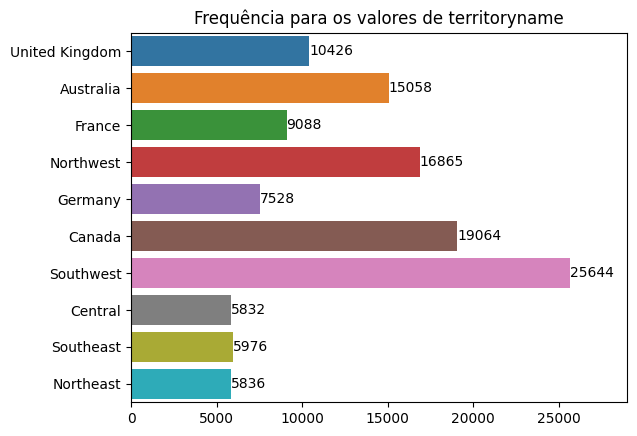

In [35]:
# Frequência dos valores:

ax = sns.countplot(data=sales, y='territoryname', hue='territoryname')
ax.set_title('Frequência para os valores de territoryname')

for container in ax.containers:
  ax.bar_label(container, label_type='edge')
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_xlim([0, 29000])
plt.show()

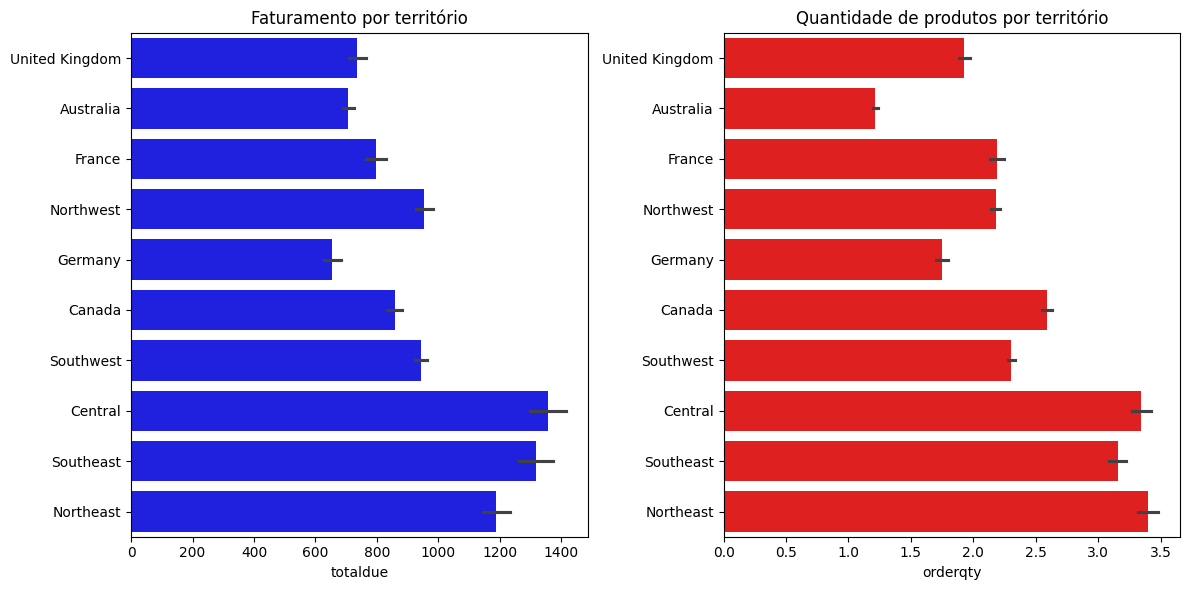

In [36]:
# Faturamento por território e quantidade de produtos vendidos:

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax1 = sns.barplot(data=sales, x='totaldue', y='territoryname', color='blue', ax=ax[0])
ax1.set_title('Faturamento por território')
ax1.set_ylabel("")
ax2 = sns.barplot(data=sales, x='orderqty', y='territoryname', color='red', ax=ax[1])
ax2.set_title('Quantidade de produtos por território')
ax2.set_ylabel("")
plt.tight_layout()
plt.show()

## 4.5. Coluna `orderqty`

In [37]:
# Resumo dos valores da coluna:

sales['orderqty'].describe()

count    121317.0
mean      2.26608
std      2.491323
min           1.0
25%           1.0
50%           1.0
75%           3.0
max          44.0
Name: orderqty, dtype: Float64

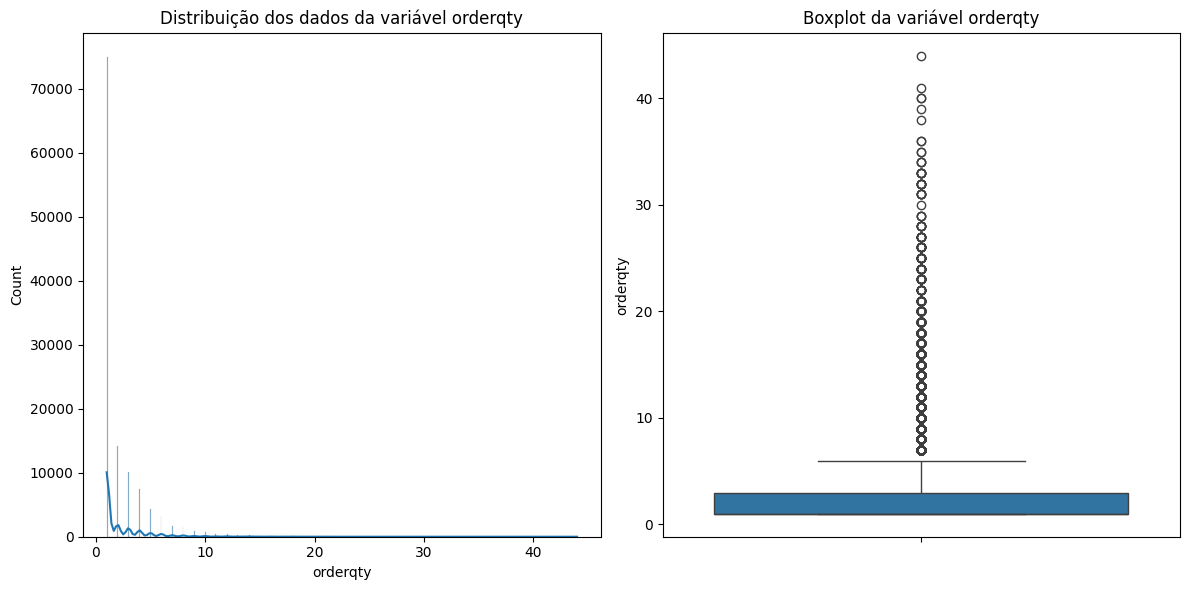

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax1 = sns.histplot(data=sales, x='orderqty', kde=True, ax=ax[0])
ax1.set_title('Distribuição dos dados da variável orderqty')
ax2 = sns.boxplot(data=sales, y='orderqty', ax=ax[1])
ax2.set_title('Boxplot da variável orderqty')
plt.tight_layout()
plt.show()

# 5. Previsão de demandas

Num primeiro momento vamos estimar a demanda para cada mês. Para isso, será feito o agrupamento pelo mês do pedido.

## 5.1. Previsão da demanda total por mês

In [39]:
# Agrupamento pelo mês do pedido:

grouped_month = sales.groupby('orderdate')[['orderqty']].sum().reset_index()
grouped_month

,orderdate,orderqty
0,2011-05,825
1,2011-06,141
2,2011-07,2209
3,2011-08,2904
4,2011-09,157
5,2011-10,5382
6,2011-11,230
7,2011-12,1040
8,2012-01,3967
9,2012-02,1442


In [40]:
# Import da biblioteca para decomposição da série temporal:

from statsmodels.tsa.seasonal import seasonal_decompose

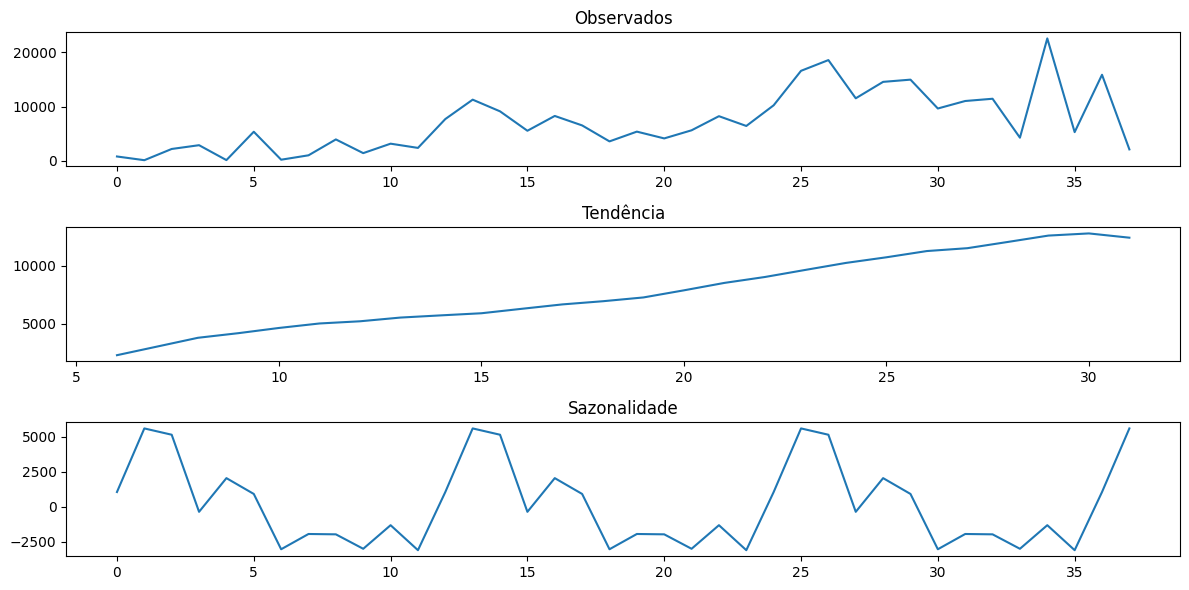

In [41]:
# Decomposição da série temporal:

result = seasonal_decompose(grouped_month['orderqty'], model='additive', period=12)
fig, ax = plt.subplots(3, 1, figsize=(12, 6))

ax1 = result.observed.plot(ax=ax[0])
ax1.set_title('Observados')
ax2 = result.trend.plot(ax=ax[1])
ax2.set_title('Tendência')
ax3 = result.seasonal.plot(ax=ax[2])
ax3.set_title('Sazonalidade')

plt.tight_layout()
plt.show()


É possível perceber que a série temporal se comporta de forma a ter uma tendência de crescimento e que há sazonalidade.

### 5.1.1. Estimativa da demanda total nos próximos 3 meses

In [42]:
# Import da biblioteca de forecast

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, Naive, SeasonalNaive

In [43]:
# Data para timestamp:

grouped_month['orderdate'] = grouped_month['orderdate'].dt.to_timestamp()
grouped_month.head()

,orderdate,orderqty
0,2011-05-01,825
1,2011-06-01,141
2,2011-07-01,2209
3,2011-08-01,2904
4,2011-09-01,157


In [44]:
grouped_month['unique_id'] = 'total'

# As colunas de data e de demanda precisam renomeadas para ds e y, respectivamente:

grouped_month = grouped_month.rename({'orderdate': 'ds', 'orderqty': 'y'}, axis=1)

In [45]:
# O dataset é dividido em treino e teste:

y_test = grouped_month.tail(3)
y_train = grouped_month.drop(y_test.index)

In [46]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         35 non-null     datetime64[ns]
 1   y          35 non-null     Int64         
 2   unique_id  35 non-null     object        
dtypes: Int64(1), datetime64[ns](1), object(1)
memory usage: 1003.0+ bytes


In [47]:
sf = StatsForecast(
    models=[AutoARIMA(season_length=12), Naive()],
    freq='MS'
)

# O modelo é ajustado com os dados de treino:

sf.fit(y_train)

StatsForecast(models=[AutoARIMA,Naive])

In [48]:
# E as estimativas são feitas com o algoritmo:

(predictions := sf.predict(h=6))

,ds,AutoARIMA,Naive
unique_id,,,
total,2014-04-01,10116.022461,22582.0
total,2014-05-01,15269.630859,22582.0
total,2014-06-01,25073.298828,22582.0
total,2014-07-01,22667.404297,22582.0
total,2014-08-01,17365.042969,22582.0
total,2014-09-01,20445.931641,22582.0


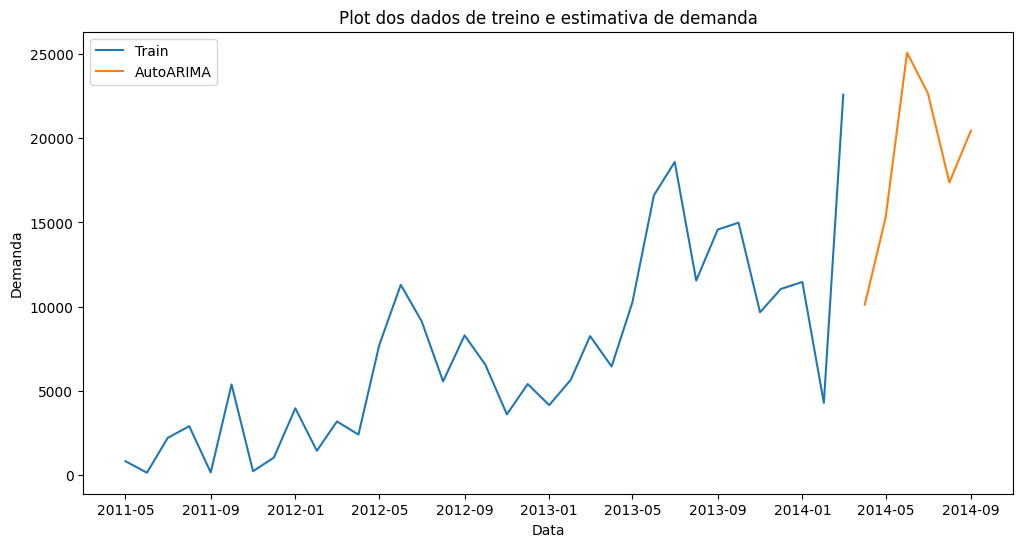

In [49]:
plt.figure(figsize=(12, 6))
plt.title('Plot dos dados de treino e estimativa de demanda')
ax1 = sns.lineplot(data=y_train, x='ds', y='y', label='Train')
ax2 = sns.lineplot(data=predictions, x='ds', y='AutoARIMA', label='AutoARIMA')
plt.ylabel('Demanda')
plt.xlabel('Data')
plt.show()

In [50]:
# É feito o merge com o dataset de teste:

(predictions := predictions.merge(y_test, on='ds'))

,ds,AutoARIMA,Naive,y,unique_id
0,2014-04-01,10116.022461,22582.0,5313,total
1,2014-05-01,15269.630859,22582.0,15884,total
2,2014-06-01,25073.298828,22582.0,2130,total


Por fim, o modelo deve ser avaliado comparando os valores estimados pelo modelo com os valores de teste.

In [51]:
# Erro percentual absoluto:

predictions['abs_pct_error'] = abs((predictions['AutoARIMA'] - predictions['y']) / predictions['y'] * 100)
predictions

,ds,AutoARIMA,Naive,y,unique_id,abs_pct_error
0,2014-04-01,10116.022461,22582.0,5313,total,90.401326
1,2014-05-01,15269.630859,22582.0,15884,total,3.867849
2,2014-06-01,25073.298828,22582.0,2130,total,1077.15018


Percebe-se que em alguns casos o modelo erra em mais de 100%, foram os casos de:

> Fevereiro de 2014;
>
> Abril de 2014;
>
> Junho de 2014;

Outras métricas com *Mean absolute error* **(MAE)**, *root of mean squared error* **(RMSE)** podem ser utilizadas para avaliar o modelo.

In [52]:
# As métricas são importadas da biblioteca sklearn:

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [53]:
print(f"MAE AutoARIMA = {mean_absolute_error(predictions['y'], predictions['AutoARIMA'])}")
print(f"RMSE AutoARIMA = {np.sqrt(mean_squared_error(predictions['y'], predictions['AutoARIMA']))}\n\n")

print(f"MAE Naive = {mean_absolute_error(predictions['y'], predictions['Naive'])}")
print(f"RMSE Naive = {np.sqrt(mean_squared_error(predictions['y'], predictions['Naive']))}")

MAE AutoARIMA = 9453.5634765625
RMSE AutoARIMA = 13538.112070716808


MAE Naive = 14806.333333333334
RMSE Naive = 15930.744583979746


### 5.1.2. Estimativa de demanda para os próximos 3 meses para cada produto em cada loja

Para a modelagem adequada do problema é necessário organizar os dados de maneira hierárquica, portanto:

In [54]:
# Agrupamento dos dados por loja e produto:

grouped_store_product = sales.groupby(['orderdate', 'storename', 'productname'])[['orderqty']].sum().reset_index('orderdate')
grouped_store_product.head()

orderdate  orderqty
storename             productname                                   
Area Bike Accessories AWC Logo Cap                 2011-05         3
                      LL Road Frame - Black, 52    2011-05         2
                      LL Road Frame - Red, 44      2011-05         2
                      LL Road Frame - Red, 60      2011-05         1
                      Long-Sleeve Logo Jersey, L   2011-05         2

In [55]:
# As hierarquias são montadas:

hierarchie = [
    ['storename', 'productname']
]

In [56]:
grouped_store_product = grouped_store_product.rename({'orderdate': 'ds', 'orderqty': 'y'}, axis=1)
grouped_store_product.head()

ds  y
storename             productname                           
Area Bike Accessories AWC Logo Cap                2011-05  3
                      LL Road Frame - Black, 52   2011-05  2
                      LL Road Frame - Red, 44     2011-05  2
                      LL Road Frame - Red, 60     2011-05  1
                      Long-Sleeve Logo Jersey, L  2011-05  2

Um dos produtos mais vendidos, como observado na **EDA** foi a *AWC Logo Cap*. Portanto, é possível realizar a decomposição da série temporal para esse produto:

In [57]:
cap = sales.query("productname == 'AWC Logo Cap'").groupby(['productname', 'orderdate'])[['orderqty']].sum().reset_index()

In [58]:
cap = cap.drop('productname', axis=1)

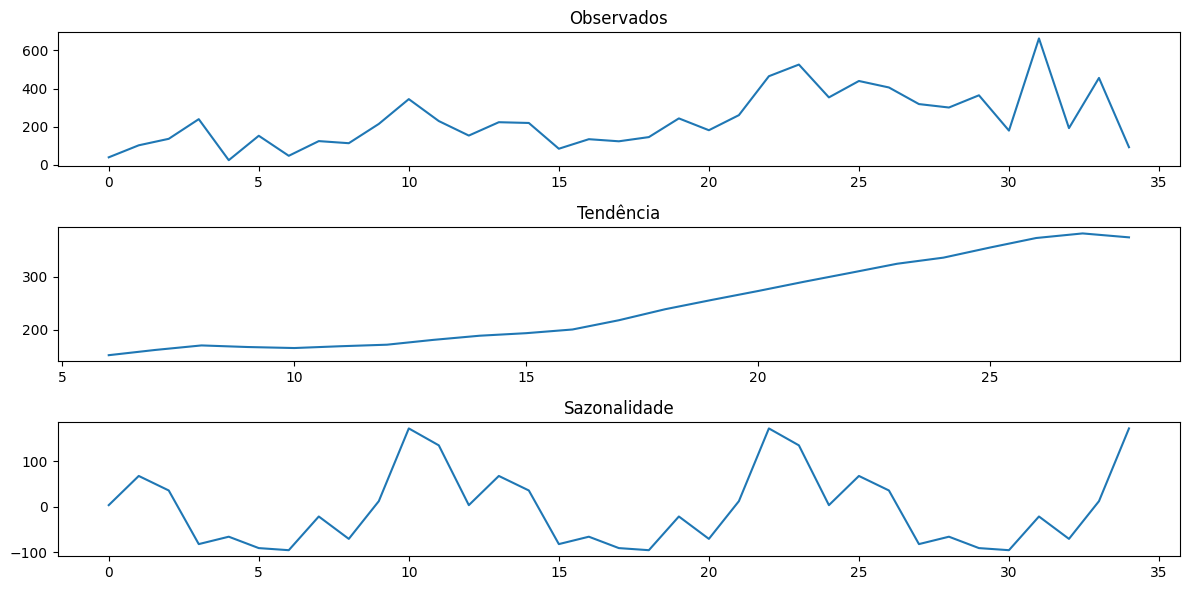

In [59]:
# Decomposição da série temporal:

result = seasonal_decompose(cap['orderqty'], model='additive', period=12)
fig, ax = plt.subplots(3, 1, figsize=(12, 6))

ax1 = result.observed.plot(ax=ax[0])
ax1.set_title('Observados')
ax2 = result.trend.plot(ax=ax[1])
ax2.set_title('Tendência')
ax3 = result.seasonal.plot(ax=ax[2])
ax3.set_title('Sazonalidade')

plt.tight_layout()
plt.show()

Ao decompor a série temporal do produto e analisá-la é possível perceber que há sazonalidade.

In [60]:
# Coluna ds para timestamp:

grouped_store_product['ds'] = grouped_store_product['ds'].dt.to_timestamp()

In [61]:
from hierarchicalforecast.utils import aggregate

# O dataset é agregado conforme a hierarquia:

y_df, s_df, tags = aggregate(grouped_store_product, hierarchie)

In [62]:
y_df = y_df.reset_index()

# Os datasets de treino e teste para a estimativa por loja e produtos:

y_test = y_df.groupby('unique_id').tail(3)
y_train = y_df.drop(y_test.index)

In [63]:
# Treinamento do modelo:

sf = StatsForecast(
    df=y_train,
    models=[AutoARIMA(season_length=12), Naive()],
    freq='MS'
)

In [64]:
# As estimativas são realizadas:

y_pred = sf.forecast(h=6, fitted=True)

In [65]:
y_pred.head()

,ds,AutoARIMA,Naive
unique_id,,,
"A Bike Store/Road-150 Red, 56",2011-08-01,2.0,2.0
"A Bike Store/Road-150 Red, 56",2011-09-01,2.0,2.0
"A Bike Store/Road-150 Red, 56",2011-10-01,2.0,2.0
"A Bike Store/Road-150 Red, 56",2011-11-01,2.0,2.0
"A Bike Store/Road-150 Red, 56",2011-12-01,2.0,2.0


O modelo é avaliado utilizando as funções da biblioteca *sklearn*:

In [66]:
# É feito o merge dos dados reais com os estimados:

y_pred = y_pred.merge(y_test, on='ds')

In [67]:
print(f"MAE AutoARIMA = {mean_absolute_error(y_pred['y'], y_pred['AutoARIMA'])}")
print(f"RMSE AutoARIMA = {np.sqrt(mean_squared_error(y_pred['y'], y_pred['AutoARIMA']))}\n\n")

print(f"MAE Naive = {mean_absolute_error(y_pred['y'], y_pred['AutoARIMA'])}")
print(f"RMSE Naive = {np.sqrt(mean_squared_error(y_pred['y'], y_pred['AutoARIMA']))}\n\n")

MAE AutoARIMA = 4.023289794939792
RMSE AutoARIMA = 8.032221536455925


MAE Naive = 4.023289794939792
RMSE Naive = 8.032221536455925




Ambos os modelos tiveram o mesmo desempenho.

### 5.1.3. Estimativa de demanda para os próximos 3 meses para cada centro de distribuição

Os dados serão agrupados por centro de distribuição e data do pedido.

In [68]:
# Agrupamento:

grouped_center = sales.groupby(['territoryname', 'orderdate'])[['orderqty']].sum().reset_index('orderdate')
grouped_center.head()

,orderdate,orderqty
territoryname,,
Australia,2011-05,1
Australia,2011-06,61
Australia,2011-07,68
Australia,2011-08,53
Australia,2011-09,64


In [69]:
hierarchie = [
    ['territoryname']
]

In [70]:
grouped_center = grouped_center.rename({'orderdate': 'ds', 'orderqty': 'y'}, axis=1)
grouped_center.head()

,ds,y
territoryname,,
Australia,2011-05,1
Australia,2011-06,61
Australia,2011-07,68
Australia,2011-08,53
Australia,2011-09,64


In [71]:
# Coluna ds para timestamp:

grouped_center['ds'] = grouped_center['ds'].dt.to_timestamp()

In [72]:
# O dataset é agregado conforme a hierarquia:

y_df, s_df, tags = aggregate(grouped_center, hierarchie)

In [73]:
y_df = y_df.reset_index()

# Os datasets de treino e teste para a estimativa por loja e produtos:

y_test = y_df.groupby('unique_id').tail(3)
y_train = y_df.drop(y_test.index)

In [74]:
# Treinamento do modelo:

sf = StatsForecast(
    df=y_train,
    models=[AutoARIMA(season_length=12), Naive()],
    freq='MS'
)

In [75]:
# As estimativas são realizadas:

y_pred = sf.forecast(h=6, fitted=True)

O modelo é avaliado utilizando as funções da biblioteca *sklearn*:

In [76]:
# É feito o merge dos dados reais com os estimados:

y_eval = y_pred.merge(y_test, on='ds')

In [77]:
y_eval

,ds,AutoARIMA,Naive,unique_id,y
0,2014-04-01,1676.000610,1477.0,Australia,1057
1,2014-04-01,1676.000610,1477.0,Canada,649
2,2014-04-01,1676.000610,1477.0,Central,6
3,2014-04-01,1676.000610,1477.0,France,443
4,2014-04-01,1676.000610,1477.0,Germany,560
...,...,...,...,...,...
279,2014-06-01,1279.452881,1652.0,United Kingdom,194
280,2014-03-01,748.938049,578.0,Central,1396
281,2014-03-01,748.938049,578.0,Northeast,1383
282,2014-03-01,975.400696,499.0,Central,1396


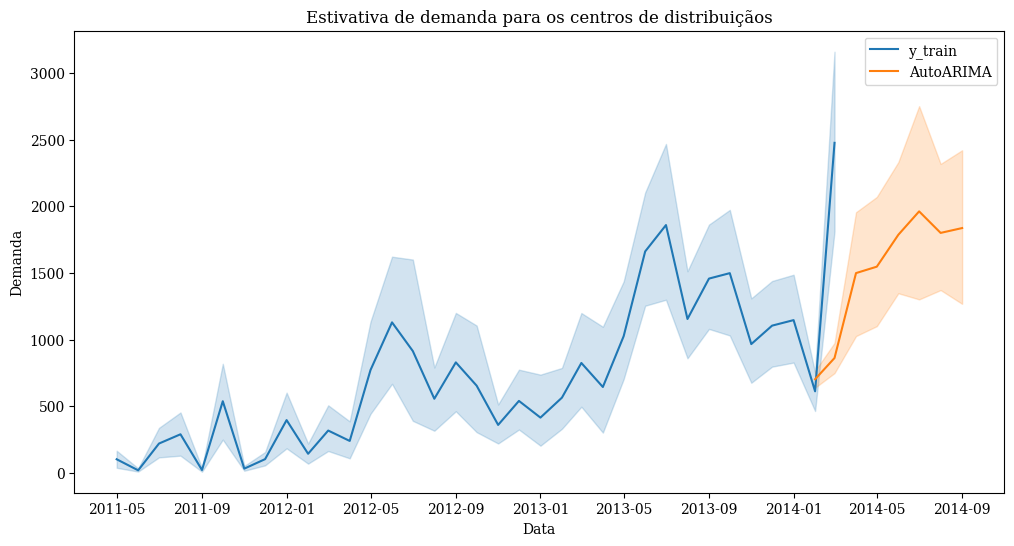

In [78]:
plt.figure(figsize=(12, 6))
plt.title('Estivativa de demanda para os centros de distribuiçãos')
ax1 = sns.lineplot(data=y_train, x='ds', y='y', label='y_train')
ax2 = sns.lineplot(data=y_pred, x='ds', y='AutoARIMA', label='AutoARIMA')
plt.ylabel('Demanda')
plt.xlabel('Data')
plt.show()

In [79]:
print(f"MAE AutoARIMA = {mean_absolute_error(y_eval['y'], y_eval['AutoARIMA'])}")
print(f"RMSE AutoARIMA = {np.sqrt(mean_squared_error(y_eval['y'], y_eval['AutoARIMA']))}\n\n")

print(f"MAE Naive = {mean_absolute_error(y_eval['y'], y_eval['AutoARIMA'])}")
print(f"RMSE Naive = {np.sqrt(mean_squared_error(y_eval['y'], y_eval['AutoARIMA']))}\n\n")

MAE AutoARIMA = 1118.1807702292858
RMSE AutoARIMA = 1370.7381158455614


MAE Naive = 1118.1807702292858
RMSE Naive = 1370.7381158455614




Para determinar qual centro de distribuição apresentou maior crescimento é feita a média das previsões dos modelos:

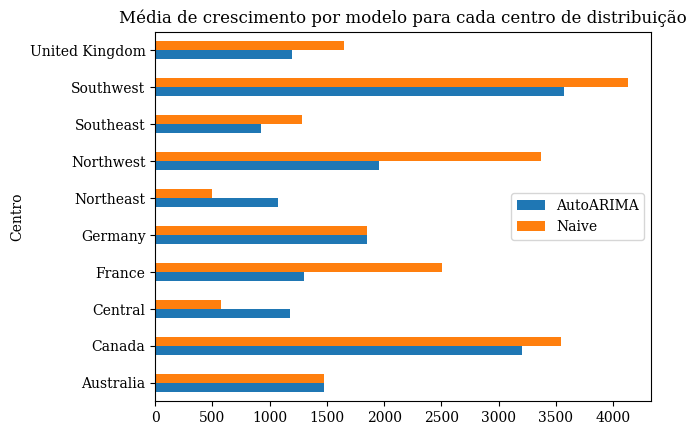

In [80]:
# Média das previsões das estimativas:

ax = y_pred.query("ds > '2014-06-01'").groupby('unique_id')[['AutoARIMA', 'Naive']].mean().plot(kind='barh')
ax.set_title('Média de crescimento por modelo para cada centro de distribuição')
ax.set_ylabel('Centro')
plt.show()

**Segundo os modelos espera-se um aumento de demanda maior no centro *Southwest* dos Estados Unidos seguido pelo centro canadense.**

### 5.1.4. Estimativa de demanda para zíperes nos próximos 3 meses com base na demanda de luvas

Para estimar a demanda dos zípeses é necessário obter apenas os registros que contenham luvas no nome do produto:

In [81]:
gloves = sales.loc[sales['productname'].str.contains('Glove')]

In [82]:
# Os valores únicos para luvas:

gloves['productname'].unique()

array(['Half-Finger Gloves, M', 'Half-Finger Gloves, L',
       'Half-Finger Gloves, S', 'Full-Finger Gloves, L',
       'Full-Finger Gloves, M', 'Full-Finger Gloves, S'], dtype=object)

In [83]:
grouped_gloves = gloves.groupby(['productname', 'orderdate'])[['orderqty']].sum().reset_index('orderdate')
grouped_gloves.head()

,orderdate,orderqty
productname,,
"Full-Finger Gloves, L",2012-05,357
"Full-Finger Gloves, L",2012-06,409
"Full-Finger Gloves, L",2012-07,347
"Full-Finger Gloves, L",2012-08,223
"Full-Finger Gloves, L",2012-09,331


In [84]:
hierarchie = [
    ['productname']
]

In [85]:
grouped_gloves = grouped_gloves.rename({'orderdate': 'ds', 'orderqty': 'y'}, axis=1)
grouped_gloves.head()

,ds,y
productname,,
"Full-Finger Gloves, L",2012-05,357
"Full-Finger Gloves, L",2012-06,409
"Full-Finger Gloves, L",2012-07,347
"Full-Finger Gloves, L",2012-08,223
"Full-Finger Gloves, L",2012-09,331


In [86]:
# Coluna ds para timestamp:

grouped_gloves['ds'] = grouped_gloves['ds'].dt.to_timestamp()

In [87]:
# O dataset é agregado conforme a hierarquia:

y_df, s_df, tags = aggregate(grouped_gloves, hierarchie)

In [88]:
y_df = y_df.reset_index()

# Os datasets de treino e teste para a estimativa por loja e produtos:

y_test = y_df.groupby('unique_id').tail(3)
y_train = y_df.drop(y_test.index)

In [89]:
# Treinamento do modelo:

sf = StatsForecast(
    df=y_train,
    models=[AutoARIMA(season_length=12), Naive()],
    freq='MS'
)

In [90]:
# As estimativas são realizadas:

y_pred = sf.forecast(h=6)

In [91]:
# É feito o merge dos dados reais com os estimados:

y_eval = y_pred.merge(y_test, on='ds')

In [92]:
y_eval

,ds,AutoARIMA,Naive,unique_id,y
0,2013-10-01,169.889526,234.0,"Full-Finger Gloves, L",6
1,2013-10-01,169.889526,234.0,"Full-Finger Gloves, M",2
2,2013-10-01,169.889526,234.0,"Full-Finger Gloves, S",3
3,2013-10-01,2.592603,4.0,"Full-Finger Gloves, L",6
4,2013-10-01,2.592603,4.0,"Full-Finger Gloves, M",2
5,2013-10-01,2.592603,4.0,"Full-Finger Gloves, S",3
6,2013-10-01,1.078784,2.0,"Full-Finger Gloves, L",6
7,2013-10-01,1.078784,2.0,"Full-Finger Gloves, M",2
8,2013-10-01,1.078784,2.0,"Full-Finger Gloves, S",3
9,2014-01-01,1.680397,4.0,"Full-Finger Gloves, L",2


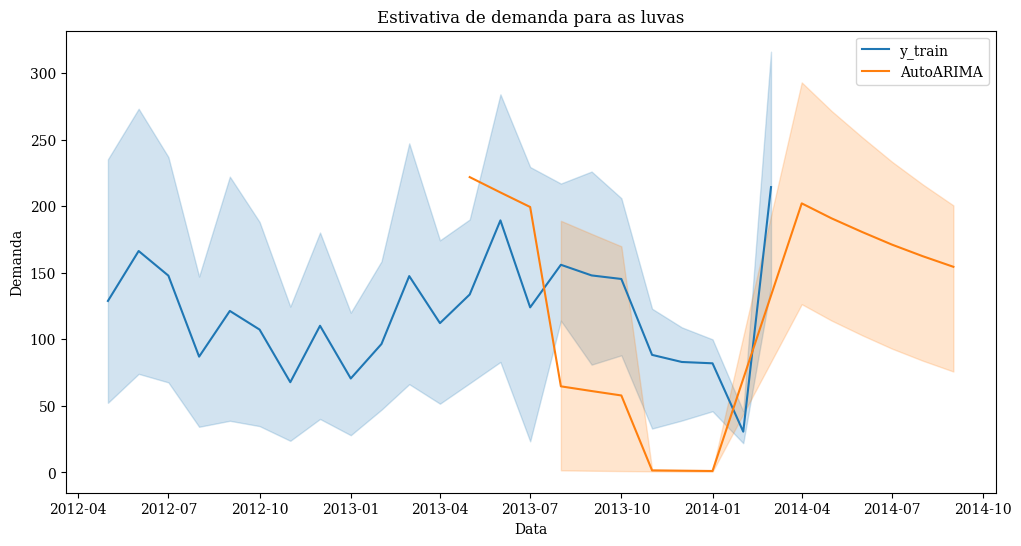

In [93]:
plt.figure(figsize=(12, 6))
plt.title('Estivativa de demanda para as luvas')
ax1 = sns.lineplot(data=y_train, x='ds', y='y', label='y_train')
ax2 = sns.lineplot(data=y_pred, x='ds', y='AutoARIMA', label='AutoARIMA')
plt.ylabel('Demanda')
plt.xlabel('Data')
plt.show()

In [94]:
print(f"MAE AutoARIMA = {mean_absolute_error(y_eval['y'], y_eval['AutoARIMA'])}")
print(f"RMSE AutoARIMA = {np.sqrt(mean_squared_error(y_eval['y'], y_eval['AutoARIMA']))}\n\n")

print(f"MAE Naive = {mean_absolute_error(y_eval['y'], y_eval['AutoARIMA'])}")
print(f"RMSE Naive = {np.sqrt(mean_squared_error(y_eval['y'], y_eval['AutoARIMA']))}\n\n")

MAE AutoARIMA = 113.93959261155597
RMSE AutoARIMA = 145.56753827291


MAE Naive = 113.93959261155597
RMSE Naive = 145.56753827291




Verifica-se a média da estimativa para os próximos 3 meses:

In [95]:
y_pred.query("ds > '2014-06-01'").groupby('unique_id')['AutoARIMA'].sum()

unique_id
Half-Finger Gloves, L    252.850922
Half-Finger Gloves, M    650.382690
Half-Finger Gloves, S    561.000000
Name: AutoARIMA, dtype: float32

**E ao todo seriam necessários cerca de 2024 zíperes.**

### **Sobre o modelo de previsão de demanda com regressão**

Um modelo de previsão de demanda, como é o caso, por possuir dados ordenados em determinado período de tempo, é um problema mais alinhado com uma solução de séries temporais. Portanto, optou-se pelo desenvolvimento de séries temporais, hierarquicas ou não para resolução dos problemas.